# NATION PREDICTION

In [1]:
# Gerekli kütüphaneleri import etme
# Dataset link: https://www.kaggle.com/datasets/tunguz/big-five-personality-test

import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Dataseti okuyup üzerinde işlem yapmak için datasetin kopyasını oluşturma

raw_df= pd.read_csv("C:/Users/melih/Documents/PersonalityTest/data-final.csv",sep='\t')
dataset=raw_df.copy()

In [3]:
# Datasette kullanılmayacak gereksiz verilerin kaldırılıp null dataların silinmesi

dataset.drop(dataset.columns[50:107], axis=1, inplace=True)
dataset.drop(dataset.columns[51:], axis=1, inplace=True)

print('Is there any missing value? ', dataset.isnull().values.any())
print('How many missing values? ', dataset.isnull().values.sum())
dataset.dropna(inplace=True)
print('Number of participants after eliminating missing values: ', len(dataset))

Is there any missing value?  True
How many missing values?  89227
Number of participants after eliminating missing values:  1013481


In [4]:
# Pozitif ve negatif soruların ayrılıp soruların türüne göre puan skalasının tekrar yapılması

positive = [  'EXT1','EXT3','EXT5','EXT7','EXT9',
              'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10',
              'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',
              'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',
              'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10', ]

negative = [ 'EXT2','EXT4','EXT6','EXT8','EXT10',
             'EST2','EST4',
             'AGR1','AGR3','AGR5','AGR7',
             'CSN2','CSN4','CSN6','CSN8',
             'OPN2','OPN4','OPN6', ]

dataset[positive] = dataset[positive].replace({1:-2, 2:-1, 3:0, 4:1, 5:2})
dataset[negative] = dataset[negative].replace({1:2, 2:1, 3:0, 4:-1, 5:-2})
cols = positive + negative
database = dataset[sorted(cols) + ['country']]

In [5]:
# Soruların karakter özelliklerine göre ayrılması

EXT = list(database.columns[:10])
EST = list(database.columns[10:20])
AGR = list(database.columns[20:30])
CSN = list(database.columns[30:40])
OPN = list(database.columns[40:50])

dimensions = [EXT,EST,AGR,CSN,OPN]
dimension_averages=["extraversion","neuroticism","agreeableness","conscientiousness","openness"]

In [6]:
# Karakter özelliklerinin puanlarına göre ortalamasının alınması ve dataya eklenmesi

for d in range(len(dimensions)):
    dataset[dimension_averages[d]] = dataset[dimensions[d]].mean(axis=1)

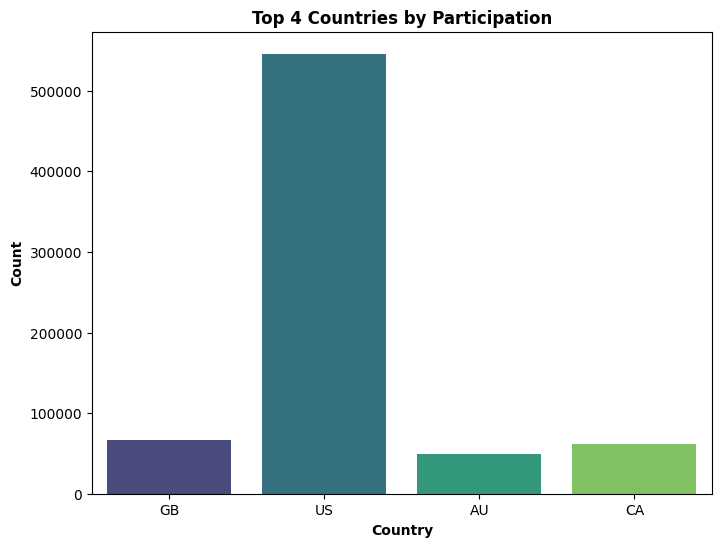

In [7]:
top_countries = dataset['country'].value_counts().nlargest(4).index
filtered_dataset = dataset[dataset['country'].isin(top_countries)]
plt.figure(figsize=(8, 6))
sns.countplot(data=filtered_dataset, x='country', palette='viridis')
plt.xlabel('Country', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Top 4 Countries by Participation', fontweight='bold')
plt.show()

In [8]:
# Nation özelliği eklenip en çok katılım yapan 4 ülkenin tanımlanması ve diğer ülkelerin else olarak tanımlanması ve country özelliğinin silinmesi

dataset['nation'] = dataset['country'].apply(lambda x: 1 if x =='US' else (2 if x =='GB' else (3 if x=='CA' else (4 if x=='AU' else 0))))
dataset.drop("country", axis=1, inplace=True)

In [9]:
# Nationda else (0) olan verilerin silinip kalan dataların tanımlamalarının tekrar

dataset = dataset[dataset['nation'] != 0]
dataset['nation'] = dataset['nation'].map({1: 0, 2: 1, 3: 2, 4: 3})

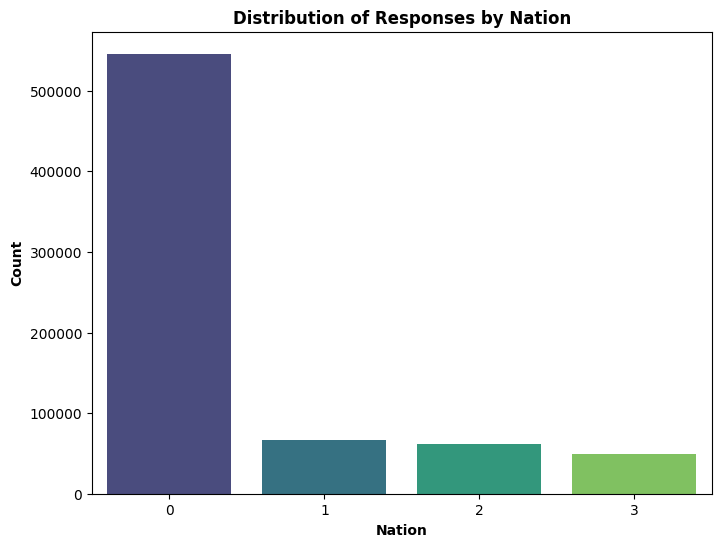

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(data=dataset, x='nation', palette='viridis')
plt.xlabel('Nation', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Distribution of Responses by Nation', fontweight='bold')
plt.show()

In [11]:
# Datasetteki verilerin sıralarının karıştırılması ve model eğitmek için gerekli olan değişenlerin tanımlanması

dataset = dataset.sample(n=len(dataset),random_state=42)
y = dataset['nation']
X = dataset.drop('nation',axis=1)

In [12]:
# Smote metoduyla sentetik data ekleyerek datanın dengesizliğinin engellenmesi

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X,y)
print('Original data size:\n',y.value_counts())
print('Data size after SMOTE is done:\n',y_smote.value_counts())

Original data size:
 nation
0    545912
1     66487
2     61805
3     49753
Name: count, dtype: int64
Data size after SMOTE is done:
 nation
0    545912
1    545912
2    545912
3    545912
Name: count, dtype: int64


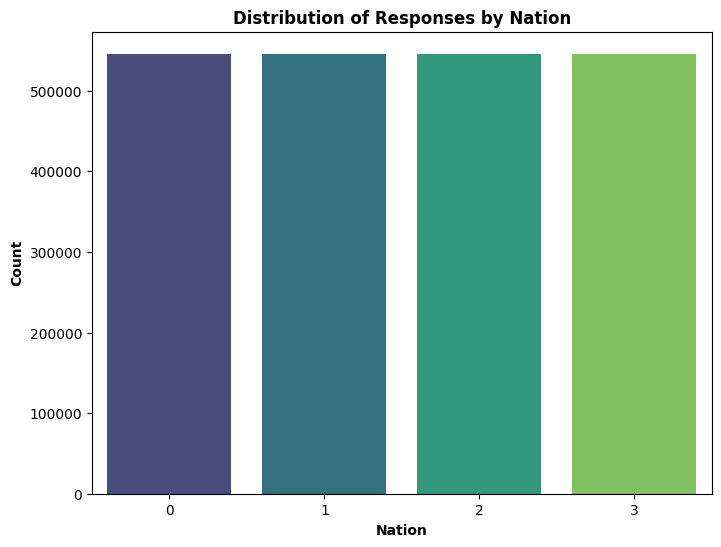

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_smote, palette='viridis')
plt.xlabel('Nation', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Distribution of Responses by Nation', fontweight='bold')
plt.show()

# TEST SIZE = 0.3

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

In [6]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=6,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.26410	validation_1-mlogloss:1.26472
[1]	validation_0-mlogloss:1.17533	validation_1-mlogloss:1.17631
[2]	validation_0-mlogloss:1.12267	validation_1-mlogloss:1.12394
[3]	validation_0-mlogloss:1.08004	validation_1-mlogloss:1.08145
[4]	validation_0-mlogloss:1.04691	validation_1-mlogloss:1.04857
[5]	validation_0-mlogloss:1.02655	validation_1-mlogloss:1.02867
[6]	validation_0-mlogloss:1.00952	validation_1-mlogloss:1.01238
[7]	validation_0-mlogloss:0.99994	validation_1-mlogloss:1.00329
[8]	validation_0-mlogloss:0.98948	validation_1-mlogloss:0.99333
[9]	validation_0-mlogloss:0.98082	validation_1-mlogloss:0.98533
[10]	validation_0-mlogloss:0.97353	validation_1-mlogloss:0.97852
[11]	validation_0-mlogloss:0.96796	validation_1-mlogloss:0.97351
[12]	validation_0-mlogloss:0.96302	validation_1-mlogloss:0.96912
[13]	validation_0-mlogloss:0.95841	validation_1-mlogloss:0.96522
[14]	validation_0-mlogloss:0.95454	validation_1-mlogloss:0.96191
[15]	validation_0-mlogloss:0.95098	

# TEST SIZE = 0.15

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.15, random_state=42)

In [5]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=6,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.26426	validation_1-mlogloss:1.26534
[1]	validation_0-mlogloss:1.17811	validation_1-mlogloss:1.17942
[2]	validation_0-mlogloss:1.12425	validation_1-mlogloss:1.12606
[3]	validation_0-mlogloss:1.07784	validation_1-mlogloss:1.07989
[4]	validation_0-mlogloss:1.04944	validation_1-mlogloss:1.05178
[5]	validation_0-mlogloss:1.02840	validation_1-mlogloss:1.03117
[6]	validation_0-mlogloss:1.01178	validation_1-mlogloss:1.01503
[7]	validation_0-mlogloss:1.00010	validation_1-mlogloss:1.00374
[8]	validation_0-mlogloss:0.99088	validation_1-mlogloss:0.99496
[9]	validation_0-mlogloss:0.98223	validation_1-mlogloss:0.98672
[10]	validation_0-mlogloss:0.97542	validation_1-mlogloss:0.98036
[11]	validation_0-mlogloss:0.96961	validation_1-mlogloss:0.97510
[12]	validation_0-mlogloss:0.96408	validation_1-mlogloss:0.96993
[13]	validation_0-mlogloss:0.95949	validation_1-mlogloss:0.96575
[14]	validation_0-mlogloss:0.95532	validation_1-mlogloss:0.96206
[15]	validation_0-mlogloss:0.95175	

# TEST SIZE = 0.10

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.1, random_state=42)

In [7]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=6,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.26398	validation_1-mlogloss:1.26501
[1]	validation_0-mlogloss:1.17807	validation_1-mlogloss:1.17925
[2]	validation_0-mlogloss:1.11651	validation_1-mlogloss:1.11802
[3]	validation_0-mlogloss:1.07680	validation_1-mlogloss:1.07844
[4]	validation_0-mlogloss:1.04498	validation_1-mlogloss:1.04661
[5]	validation_0-mlogloss:1.02466	validation_1-mlogloss:1.02675
[6]	validation_0-mlogloss:1.01020	validation_1-mlogloss:1.01272
[7]	validation_0-mlogloss:0.99876	validation_1-mlogloss:1.00148
[8]	validation_0-mlogloss:0.98838	validation_1-mlogloss:0.99143
[9]	validation_0-mlogloss:0.98045	validation_1-mlogloss:0.98394
[10]	validation_0-mlogloss:0.97347	validation_1-mlogloss:0.97740
[11]	validation_0-mlogloss:0.96715	validation_1-mlogloss:0.97149
[12]	validation_0-mlogloss:0.96240	validation_1-mlogloss:0.96713
[13]	validation_0-mlogloss:0.95828	validation_1-mlogloss:0.96342
[14]	validation_0-mlogloss:0.95464	validation_1-mlogloss:0.96023
[15]	validation_0-mlogloss:0.95145	

In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=7,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.23413	validation_1-mlogloss:1.23451
[1]	validation_0-mlogloss:1.14935	validation_1-mlogloss:1.15041
[2]	validation_0-mlogloss:1.09606	validation_1-mlogloss:1.09784
[3]	validation_0-mlogloss:1.05796	validation_1-mlogloss:1.06073
[4]	validation_0-mlogloss:1.03447	validation_1-mlogloss:1.03813
[5]	validation_0-mlogloss:1.01227	validation_1-mlogloss:1.01681
[6]	validation_0-mlogloss:0.99458	validation_1-mlogloss:1.00012
[7]	validation_0-mlogloss:0.98133	validation_1-mlogloss:0.98777
[8]	validation_0-mlogloss:0.97097	validation_1-mlogloss:0.97808
[9]	validation_0-mlogloss:0.96190	validation_1-mlogloss:0.96974
[10]	validation_0-mlogloss:0.95382	validation_1-mlogloss:0.96277
[11]	validation_0-mlogloss:0.94718	validation_1-mlogloss:0.95704
[12]	validation_0-mlogloss:0.94164	validation_1-mlogloss:0.95239
[13]	validation_0-mlogloss:0.93707	validation_1-mlogloss:0.94875
[14]	validation_0-mlogloss:0.93244	validation_1-mlogloss:0.94504
[15]	validation_0-mlogloss:0.92897	

In [17]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=8,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.21722	validation_1-mlogloss:1.21926
[1]	validation_0-mlogloss:1.12674	validation_1-mlogloss:1.13135
[2]	validation_0-mlogloss:1.07044	validation_1-mlogloss:1.07664
[3]	validation_0-mlogloss:1.02967	validation_1-mlogloss:1.03715
[4]	validation_0-mlogloss:1.00039	validation_1-mlogloss:1.00911
[5]	validation_0-mlogloss:0.97994	validation_1-mlogloss:0.99041
[6]	validation_0-mlogloss:0.96432	validation_1-mlogloss:0.97619
[7]	validation_0-mlogloss:0.95087	validation_1-mlogloss:0.96436
[8]	validation_0-mlogloss:0.94036	validation_1-mlogloss:0.95548
[9]	validation_0-mlogloss:0.93109	validation_1-mlogloss:0.94777
[10]	validation_0-mlogloss:0.92281	validation_1-mlogloss:0.94080
[11]	validation_0-mlogloss:0.91601	validation_1-mlogloss:0.93509
[12]	validation_0-mlogloss:0.91013	validation_1-mlogloss:0.93050
[13]	validation_0-mlogloss:0.90329	validation_1-mlogloss:0.92529
[14]	validation_0-mlogloss:0.89727	validation_1-mlogloss:0.92090
[15]	validation_0-mlogloss:0.89183	

In [18]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=9,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.19730	validation_1-mlogloss:1.20085
[1]	validation_0-mlogloss:1.10238	validation_1-mlogloss:1.10910
[2]	validation_0-mlogloss:1.04236	validation_1-mlogloss:1.05165
[3]	validation_0-mlogloss:1.00058	validation_1-mlogloss:1.01287
[4]	validation_0-mlogloss:0.97111	validation_1-mlogloss:0.98619
[5]	validation_0-mlogloss:0.94858	validation_1-mlogloss:0.96668
[6]	validation_0-mlogloss:0.93187	validation_1-mlogloss:0.95250
[7]	validation_0-mlogloss:0.91614	validation_1-mlogloss:0.93953
[8]	validation_0-mlogloss:0.90310	validation_1-mlogloss:0.92954
[9]	validation_0-mlogloss:0.89273	validation_1-mlogloss:0.92141
[10]	validation_0-mlogloss:0.88274	validation_1-mlogloss:0.91418
[11]	validation_0-mlogloss:0.87342	validation_1-mlogloss:0.90742
[12]	validation_0-mlogloss:0.86412	validation_1-mlogloss:0.90101
[13]	validation_0-mlogloss:0.85633	validation_1-mlogloss:0.89573
[14]	validation_0-mlogloss:0.84883	validation_1-mlogloss:0.89088
[15]	validation_0-mlogloss:0.84073	

In [19]:
xgb_model = xgb.XGBClassifier(learning_rate=1, 
              max_depth=10,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=10000, 
              objective='binary:logistic', 
              random_state=42,
              early_stopping_rounds=10)

xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)])

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-mlogloss:1.17732	validation_1-mlogloss:1.18350
[1]	validation_0-mlogloss:1.07801	validation_1-mlogloss:1.09011
[2]	validation_0-mlogloss:1.01803	validation_1-mlogloss:1.03556
[3]	validation_0-mlogloss:0.97232	validation_1-mlogloss:0.99522
[4]	validation_0-mlogloss:0.93784	validation_1-mlogloss:0.96573
[5]	validation_0-mlogloss:0.91119	validation_1-mlogloss:0.94449
[6]	validation_0-mlogloss:0.88818	validation_1-mlogloss:0.92692
[7]	validation_0-mlogloss:0.86936	validation_1-mlogloss:0.91312
[8]	validation_0-mlogloss:0.85270	validation_1-mlogloss:0.90109
[9]	validation_0-mlogloss:0.83601	validation_1-mlogloss:0.88955
[10]	validation_0-mlogloss:0.82151	validation_1-mlogloss:0.87997
[11]	validation_0-mlogloss:0.80832	validation_1-mlogloss:0.87093
[12]	validation_0-mlogloss:0.79565	validation_1-mlogloss:0.86280
[13]	validation_0-mlogloss:0.78369	validation_1-mlogloss:0.85496
[14]	validation_0-mlogloss:0.77435	validation_1-mlogloss:0.84931
[15]	validation_0-mlogloss:0.76327	